In our lab today, we'll be replicating our study of political polarization on the US using congressional speeches. We're going to predict the party of the person who delivered each speech. The basic idea is that more polarized periods will make it easier to predict party membership.

Let's start by getting our environment ready.

In [1]:
from text_analytics import TextAnalytics
import os
import pandas as pd

ai = TextAnalytics()
ai.data_dir = os.path.join(".", "data")
print("Done!")

Done!


Our data will be congressional speeches, from 1931 to 2016. The means we have one classifier for each year. We also classify the two chambers separately (the House and the Senate). This is a lot of data to process, so we're just going to load our classification results. So, we'll have a dataframe that represents some figures from each year.

In [2]:
file = os.path.join(ai.data_dir, "congress_by_speech.csv")
df = pd.read_csv(file, index_col = 0)
print(df)

     Year Chamber Result          Type  Precision  Recall  F-Score  Support
0    1931       H      +             D       0.76    0.45     0.56      317
1    1931       H      +             R       0.70    0.90     0.79      459
2    1931       H      +  weighted_avg       0.73    0.72     0.70      776
3    1931       H      -  weighted_avg       0.35    0.59     0.44      776
4    1931       S      +             D       0.69    0.79     0.73      397
..    ...     ...    ...           ...        ...     ...      ...      ...
683  2016       H      -  weighted_avg       0.26    0.51     0.34      919
684  2016       S      +             D       0.81    0.75     0.78      201
685  2016       S      +             R       0.81    0.86     0.83      252
686  2016       S      +  weighted_avg       0.81    0.81     0.81      453
687  2016       S      -  weighted_avg       0.31    0.56     0.40      453

[688 rows x 8 columns]


We're not running the full classifications, because that would take awhile (we'd need 170 different models). Instead we're going to manipulate this dataframe of results to get what we need.

We'll use groupby to go through one year at a time and get the information we need.

In [3]:
h_results = []
s_results = []
speeches_by_party = []

for year, year_df in df.groupby("Year"):
        year_df.reset_index(inplace=True)

        #Save results for house
        h_results.append([year, "Baseline", year_df.loc[3,"F-Score"]])
        h_results.append([year, "Actual", year_df.loc[2,"F-Score"]])
        
        #Save results for senate
        s_results.append([year, "Baseline", year_df.loc[7,"F-Score"]])
        s_results.append([year, "Actual", year_df.loc[6,"F-Score"]])
        
        #Save total party counts
        speeches_by_party.append([year, "D", year_df.loc[0,"Support"]+year_df.loc[4,"Support"]])
        speeches_by_party.append([year, "R", year_df.loc[1,"Support"]+year_df.loc[5,"Support"]])

#Now we've gone through each year; make a new dataframe with our baselines included
h_results_df = pd.DataFrame(h_results, columns = ["Year", "Type", "F-Score"])
s_results_df = pd.DataFrame(s_results, columns = ["Year", "Type", "F-Score"])
speeches_df = pd.DataFrame(speeches_by_party, columns = ["Year", "Party", "Count"])
print(h_results_df)
print(speeches_df)

     Year      Type  F-Score
0    1931  Baseline     0.44
1    1931    Actual     0.70
2    1932  Baseline     0.34
3    1932    Actual     0.64
4    1933  Baseline     0.50
..    ...       ...      ...
167  2014    Actual     0.76
168  2015  Baseline     0.33
169  2015    Actual     0.77
170  2016  Baseline     0.34
171  2016    Actual     0.77

[172 rows x 3 columns]
     Year Party  Count
0    1931     D    714
1    1931     R    770
2    1932     D   1960
3    1932     R   1832
4    1933     D   1653
..    ...   ...    ...
167  2014     R    843
168  2015     D   1105
169  2015     R   1163
170  2016     D    651
171  2016     R    721

[172 rows x 3 columns]


The majority baseline changes a lot from year to year, because there is a different mix of speeches. And for political polarization, we're only interested in accuracy above that naive baseline. Let's take a look at the number of speeches by party over this period to see whether this variation might influence the results.

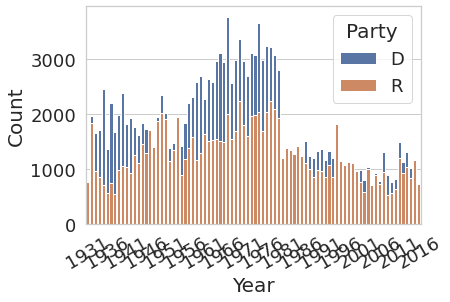

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
sns.set_theme(style="whitegrid")

ax = sns.barplot(y="Count", x="Year", hue="Party", data=speeches_df, dodge = False)

# figure size in inches
rcParams['figure.figsize'] = 15,8
rcParams['font.size'] = 15

ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

every_nth = 5
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
plt.xlabel("Year",size=20)
plt.ylabel("Count",size=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(title='Party', fontsize=18, title_fontsize=20)

Now this "Improvement" column represents the predication accuracy adjusted for a naive baseline. This no longer tells us about the performance of the classifier in each case, but it does give us a relative representation of performance over time. Let's turn this into a line chart over time.

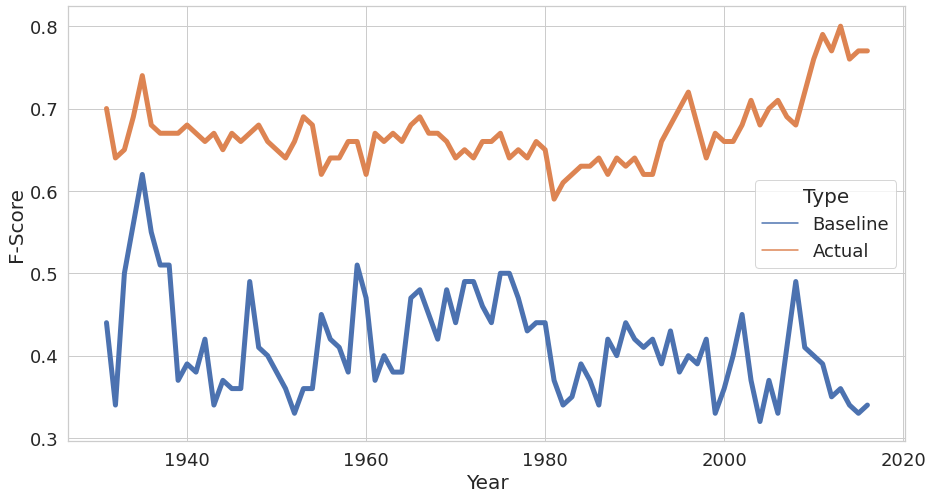

In [5]:
sns.lineplot(data = h_results_df, y = "F-Score", x = "Year", hue = "Type", linewidth =5)

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
rcParams['font.size'] = 15

plt.xlabel("Year",size=20)
plt.ylabel("F-Score",size=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(title='Type', fontsize=18, title_fontsize=20)

And now we have a text-based measure of political polarization over the course of American history!

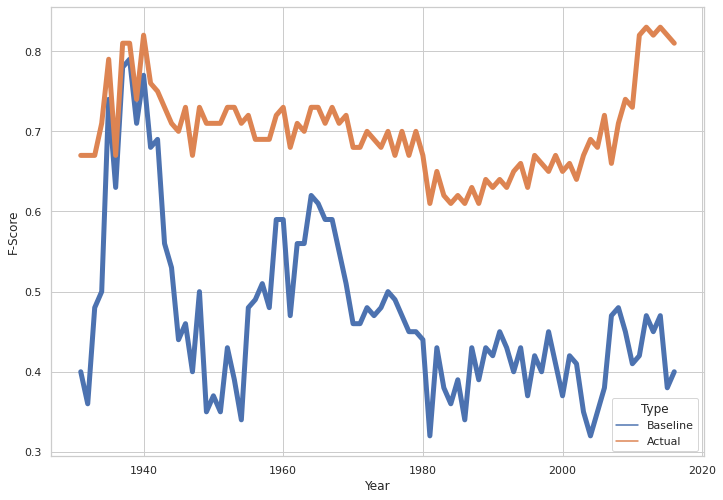

In [6]:
sns.lineplot(data = s_results_df, y = "F-Score", x = "Year", hue = "Type", linewidth =5)

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
rcParams['font.size'] = 15

To what degree is the prediction accuracy of the party classifier correlated with the majority baseline? In other words, can most of the fluctuation be described by the simple change in membership of the house and senate? Let's find out.

In [7]:
#Get actual / baseline results for the house
h_actual = h_results_df.loc[h_results_df["Type"] == "Actual"]
h_baseline = h_results_df.loc[h_results_df["Type"] == "Baseline"]

#GEt actual / baseline results for the senate
s_actual = s_results_df.loc[s_results_df["Type"] == "Actual"]
s_baseline = s_results_df.loc[s_results_df["Type"] == "Baseline"]

print(h_actual)
print(s_actual)

     Year    Type  F-Score
1    1931  Actual     0.70
3    1932  Actual     0.64
5    1933  Actual     0.65
7    1934  Actual     0.69
9    1935  Actual     0.74
..    ...     ...      ...
163  2012  Actual     0.77
165  2013  Actual     0.80
167  2014  Actual     0.76
169  2015  Actual     0.77
171  2016  Actual     0.77

[86 rows x 3 columns]
     Year    Type  F-Score
1    1931  Actual     0.67
3    1932  Actual     0.67
5    1933  Actual     0.67
7    1934  Actual     0.71
9    1935  Actual     0.79
..    ...     ...      ...
163  2012  Actual     0.83
165  2013  Actual     0.82
167  2014  Actual     0.83
169  2015  Actual     0.82
171  2016  Actual     0.81

[86 rows x 3 columns]


In [8]:
from scipy.stats import pearsonr

h_cor = pearsonr(h_actual.loc[:,"F-Score"], h_baseline.loc[:,"F-Score"])
s_cor = pearsonr(s_actual.loc[:,"F-Score"], s_baseline.loc[:,"F-Score"])

print("Correlation", "Significance")
print(h_cor)
print(s_cor)

Correlation Significance
(-0.11449839614408105, 0.2938405116113274)
(0.5170357701294523, 3.4541334643112694e-07)


So, for the House there is no significant correlation between the majority baseline (the number of speeches by party) and the classifier performance. This indicates that there is a textual marker of party throughout this corpus. Is the difference between the actual performance and the baseline significant?

In [9]:
from scipy.stats import ttest_ind

h_sig = ttest_ind(h_actual.loc[:,"F-Score"], h_baseline.loc[:,"F-Score"])
s_sig = ttest_ind(s_actual.loc[:,"F-Score"], s_baseline.loc[:,"F-Score"])

print("Statistic", "P-Value")
print(h_sig)
print(s_sig)

Statistic P-Value
Ttest_indResult(statistic=32.94687108675025, pvalue=1.0141954611286991e-75)
Ttest_indResult(statistic=17.516854041080908, pvalue=6.410416638396384e-40)


In both cases, there is a very significant difference between the actual F-Scores and the majority baseline F-scores. This tells us that the classifier is picking up on meaningful differences between the parties.

The previous results have used a separate feature space for year, finding the vocab and fitting the TF-IDF weightings. What if we used a single feature space across the entire data set? This is a different design choice and we will see which works best.

In [10]:
file = os.path.join(ai.data_dir, "congress_by_speech_shared_features.csv")
df = pd.read_csv(file, index_col = 0)
print(df)

     Year Chamber Result          Type  Precision  Recall  F-Score  Support
0    1931       H      +             D       0.67    0.46     0.54      310
1    1931       H      +             R       0.70    0.85     0.77      466
2    1931       H      +  weighted_avg       0.69    0.69     0.68      776
3    1931       H      -  weighted_avg       0.36    0.60     0.45      776
4    1931       S      +             D       0.64    0.80     0.71      368
..    ...     ...    ...           ...        ...     ...      ...      ...
683  2016       H      -  weighted_avg       0.30    0.55     0.39      919
684  2016       S      +             D       0.76    0.74     0.75      200
685  2016       S      +             R       0.80    0.82     0.81      253
686  2016       S      +  weighted_avg       0.78    0.78     0.78      453
687  2016       S      -  weighted_avg       0.31    0.56     0.40      453

[688 rows x 8 columns]


In [11]:
h_results_shared_features = []
s_results_shared_features = []

for year, year_df in df.groupby("Year"):
        year_df.reset_index(inplace=True)

        #Save results for house
        h_results_shared_features.append([year, "Baseline", year_df.loc[3,"F-Score"]])
        h_results_shared_features.append([year, "Actual", year_df.loc[2,"F-Score"]])
        
        #Save results for senate
        s_results_shared_features.append([year, "Baseline", year_df.loc[7,"F-Score"]])
        s_results_shared_features.append([year, "Actual", year_df.loc[6,"F-Score"]])

#Now we've gone through each year; make a new dataframe with our baselines included
h_results_shared_features_df = pd.DataFrame(h_results_shared_features, columns = ["Year", "Type", "F-Score"])
s_results_shared_features_df = pd.DataFrame(s_results_shared_features, columns = ["Year", "Type", "F-Score"])
print(h_results_shared_features_df)
print(s_results_shared_features_df)

     Year      Type  F-Score
0    1931  Baseline     0.45
1    1931    Actual     0.68
2    1932  Baseline     0.38
3    1932    Actual     0.66
4    1933  Baseline     0.51
..    ...       ...      ...
167  2014    Actual     0.76
168  2015  Baseline     0.34
169  2015    Actual     0.78
170  2016  Baseline     0.39
171  2016    Actual     0.78

[172 rows x 3 columns]
     Year      Type  F-Score
0    1931  Baseline     0.36
1    1931    Actual     0.66
2    1932  Baseline     0.36
3    1932    Actual     0.68
4    1933  Baseline     0.50
..    ...       ...      ...
167  2014    Actual     0.80
168  2015  Baseline     0.40
169  2015    Actual     0.83
170  2016  Baseline     0.40
171  2016    Actual     0.78

[172 rows x 3 columns]


In [12]:
h_actual_refit = h_results_df.loc[h_results_df["Type"] == "Actual"]
h_actual_refit.loc[:,"Type"] = "Refit"

h_actual_norefit = h_results_shared_features_df.loc[h_results_shared_features_df["Type"] == "Actual"]
h_actual_norefit.loc[:,"Type"] = "No_Refit"

full_comparison = pd.concat([h_actual_refit, h_actual_norefit], axis = 0)
print(full_comparison)

     Year      Type  F-Score
1    1931     Refit     0.70
3    1932     Refit     0.64
5    1933     Refit     0.65
7    1934     Refit     0.69
9    1935     Refit     0.74
..    ...       ...      ...
163  2012  No_Refit     0.77
165  2013  No_Refit     0.79
167  2014  No_Refit     0.76
169  2015  No_Refit     0.78
171  2016  No_Refit     0.78

[172 rows x 3 columns]


/opt/miniconda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


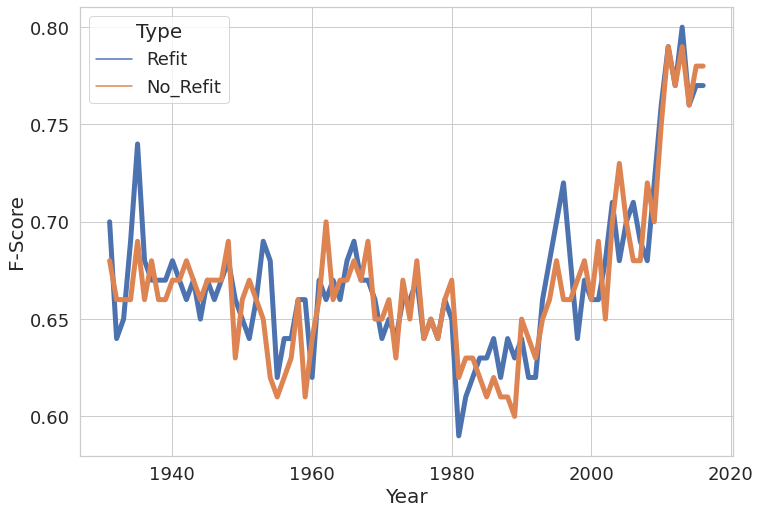

In [13]:
sns.lineplot(data = full_comparison, y = "F-Score", x = "Year", hue = "Type", linewidth =5)

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
rcParams['font.size'] = 15

plt.xlabel("Year",size=20)
plt.ylabel("F-Score",size=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(title='Type', fontsize=18, title_fontsize=20)

In [14]:
refit_sig = ttest_ind(h_actual_norefit.loc[:,"F-Score"], h_actual_refit.loc[:,"F-Score"])

print("Statistic", "P-Value")
print(refit_sig)

refit_cor = pearsonr(h_actual_norefit.loc[:,"F-Score"], h_actual_refit.loc[:,"F-Score"])

print("\nCorrelation", "Significance")
print(refit_cor)

Statistic P-Value
Ttest_indResult(statistic=-0.4670078718850852, pvalue=0.6410922334747068)

Correlation Significance
(0.8666722891376585, 4.2708297610026306e-27)
